In [ ]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/audio/ipynb/ctc_asr.ipynb#scrollTo=-DCz-Mkctmon

In [2]:
!pip install opencv-python matplotlib imageio

In [5]:
!pip install gpustat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 21.8 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19867 sha256=5cbdd8e0136ab3f26b3c6d389c309528a10d3b2d332462e9cd7721fa346c5fa7
  Stored in directory: /root/.cache/pip/wheels/ce/13/aa/145d9d670feb2cf4a0691b9a3552aafc8a1b49c5162a0f379d
Successfully built gpustat


In [2]:
!gpustat

nfckdnn9hv           Mon Jan 16 05:53:07 2023  510.73.05
[0] NVIDIA RTX A5000 | 50°C,   0 % |   307 / 24564 MB |


In [4]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.8 MB/s eta 0:00:00


In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from jiwer import wer

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [7]:
def load_video(path:str) -> List[float]: 
    #print(path)
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
def load_alignments(path:str) -> List[str]: 
    #print(path)
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
with open('./data/alignments/s1/bbal6n.align', 'r') as f: 
        lines = f.readlines() 

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
test_path = './data/s1/bbal6n.mpg'

In [14]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.460374  ],
          [ 1.460374  ],
          [ 1.4209044 ],
          ...,
          [ 0.15787826],
          [ 0.19734783],
          [ 0.07893913]],
 
         [[ 1.460374  ],
          [ 1.460374  ],
          [ 1.4209044 ],
          ...,
          [ 0.15787826],
          [ 0.07893913],
          [ 0.03946957]],
 
         [[ 1.4209044 ],
          [ 1.4209044 ],
          [ 1.3814349 ],
          ...,
          [ 0.07893913],
          [ 0.07893913],
          [ 0.07893913]],
 
         ...,
 
         [[ 0.9472696 ],
          [ 0.9472696 ],
          [ 0.9472696 ],
          ...,
          [ 9.946331  ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.9472696 ],
          [ 0.9472696 ],
          [ 0.9472696 ],
          ...,
          [ 9.906861  ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.9472696 ],
          [ 0.9472696 ],
          [ 0.9472696 ],
          

In [15]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Dataloader

In [16]:
from matplotlib import pyplot as plt

In [17]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [18]:
test = data.as_numpy_iterator()

In [19]:
val = test.next(); val[0]

array([[[[[1.2952235 ],
          [1.2190338 ],
          [1.3714131 ],
          ...,
          [0.22856885],
          [0.19047405],
          [0.19047405]],

         [[0.9142754 ],
          [0.99046504],
          [1.2571287 ],
          ...,
          [0.22856885],
          [0.19047405],
          [0.19047405]],

         [[0.64761174],
          [1.1809391 ],
          [1.409508  ],
          ...,
          [0.30475846],
          [0.22856885],
          [0.22856885]],

         ...,

         [[1.0285598 ],
          [1.0285598 ],
          [1.0285598 ],
          ...,
          [0.03809481],
          [0.03809481],
          [0.03809481]],

         [[1.0285598 ],
          [1.0285598 ],
          [1.0285598 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0285598 ],
          [1.0285598 ],
          [1.0285598 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.4095

In [20]:
#imageio.mimsave('./animation.gif', val[0][1], fps=10)

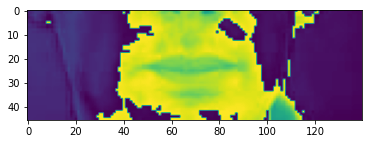

In [21]:
plt.imshow(val[0][0][0])

In [22]:
val[1]

array([[19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39,  9, 39, 20,
        23, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39,  2, 39,  6,
        15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [23]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white at i two please'>

# Build NN

In [24]:
import os 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [25]:
model = Sequential()
#Spatial Conv
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))
#model.add(Reshape((255, -1)))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [28]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [29]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lla   rreeee           eee   oo'>

In [33]:
model.input_shape

(None, 75, 46, 140, 1)

In [34]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [35]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [36]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [37]:
val[1]

array([[19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39,  9, 39, 20,
        23, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39,  2, 39,  6,
        15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [38]:
model.predict(val[0])

1/1 [==============================] - 0s 42ms/step


array([[[7.57830974e-04, 7.24005699e-03, 2.22939119e-01, ...,
         1.05527535e-04, 1.21851231e-03, 1.46388763e-03],
        [8.98813247e-04, 2.06224352e-01, 5.44086052e-03, ...,
         6.58392455e-05, 1.61253416e-03, 2.06495891e-03],
        [5.81838423e-04, 2.84210712e-01, 7.84076750e-04, ...,
         4.99463131e-05, 9.50505398e-03, 7.67203572e-04],
        ...,
        [9.84990418e-01, 3.98431757e-06, 1.75111541e-06, ...,
         2.38379607e-06, 2.82273481e-06, 1.48481950e-02],
        [9.38409474e-03, 6.39422524e-06, 5.02351031e-06, ...,
         1.98712223e-06, 2.09418886e-06, 9.90402043e-01],
        [9.98169541e-01, 3.30450416e-06, 1.51286326e-06, ...,
         2.84187718e-06, 3.56529745e-06, 1.69270195e-03]],

       [[7.58199021e-04, 7.33087491e-03, 2.23377004e-01, ...,
         1.03462036e-04, 1.23698730e-03, 1.47949113e-03],
        [8.82398861e-04, 2.07154840e-01, 5.20726806e-03, ...,
         6.38455749e-05, 1.59725803e-03, 2.05415953e-03],
        [5.84574533e-04, 

In [39]:
CTCLoss(val[1], model.predict(val[0]))

1/1 [==============================] - 0s 41ms/step


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[51.604942],
       [55.160603]], dtype=float32)>

In [237]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/audio/ipynb/ctc_asr.ipynb#scrollTo=bkMkVhgrSNKu

In [40]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join([vocab[word] + ' ' for word in data[1][x]]).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join([vocab[word] + ' ' for word in decoded[x] ]).numpy().decode('utf-8'))
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [41]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [43]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [44]:
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
example_callback = CallbackEval(data.take(1))

In [ ]:
# 16 overnight 1
model.fit(data, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])
#model.fit(data.take(1), epochs=1, callbacks=[schedule_callback, example_callback])

Epoch 1/50
1/1 [==============================] - 1s 1s/steps - loss: 52.28
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : set blue with h eight please
Prediction: pla re e ao
----------------------------------------------------------------------------------------------------
Target    : set blue with h eight please
Prediction: pla re e ao
----------------------------------------------------------------------------------------------------
499/499 [==============================] - 193s 374ms/step - loss: 52.2829 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 0s 45ms/step- loss: 50.84
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
-------------------------------------------------------------------------

In [ ]:
len(vocab) 

In [ ]:
tf.argmax(model.predict(val[0])[0],axis=1)

# Make a Prediction 

In [27]:
model.load_weights('models/checkpoint')

In [100]:
test_data = data.as_numpy_iterator()

In [101]:
sample = test_data.next()

In [102]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 545ms/step


In [103]:
[num_to_char(word) for word in tf.argmax(yhat,axis=1)]

[<tf.Tensor: shape=(54,), dtype=string, numpy=
 array([b'f', b'j', b'sil', b'sil', b'set', b'place', b'place', b'm',
        b'set', b'place', b'm', b'm', b'm', b'set', b'sil', b'place',
        b'set', b'sil', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n',
        b'n', b'n', b'blue', b'please', b'blue', b'please', b'blue',
        b'red', b'red', b'red', b'blue', b'in', b'blue', b'red', b'blue',
        b'in', b'in', b'please', b'please', b'at', b'red', b'please',
        b'in', b'blue', b'in', b'in', b'please', b'three'], dtype=object)>,
 <tf.Tensor: shape=(54,), dtype=string, numpy=
 array([b'f', b'j', b'sil', b'sil', b'set', b'place', b'place', b'm',
        b'set', b'place', b'm', b'm', b'm', b'set', b'sil', b'place',
        b'set', b'sil', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n',
        b'n', b'n', b'blue', b'please', b'blue', b'please', b'blue',
        b'red', b'red', b'red', b'blue', b'in', b'blue', b'red', b'blue',
        b'in', b'in', b'please', b'please', b'at',

In [112]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [113]:
decoded

array([[ 1, 14,  9,  4, 12,  1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, 14,  9,  4, 12,  1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int64)

In [114]:
print(np.array([[vocab[word] for word in sentence] for sentence in decoded]))

[['sil' 'lay' 'blue' 'at' 'now' 'sil' '' '' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b']
 ['sil' 'lay' 'blue' 'at' 'now' 'sil' '' '' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
  'b' 'b' 'b' 'b' 'b' 'b']]


In [115]:
[[vocab[word] for word in sentence] for sentence in sample[1]]

[['sil',
  'place',
  'white',
  'by',
  'd',
  'six',
  'now',
  'sil',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 ['sil',
  'place',
  'red',
  'with',
  'q',
  'four',
  'please',
  'sil',
  '',
  '',
  '',
  '',
  '',
  '',
  '']]

# Load Model

In [37]:
from itertools import groupby

In [34]:
sentences = [[vocab[word] for word in batch] for batch in yhat.argmax(axis=-1)]
original = [[vocab[word] for word in batch] for batch in val[1].argmax(axis=-1)]

In [39]:
[key for key, _group in groupby(sentences[0])]

['',
 'sil',
 'set',
 'place',
 'green',
 'white',
 'by',
 'six',
 'zero',
 'soon',
 'please',
 'soon',
 'please',
 'sil']

In [40]:
[key for key, _group in groupby(original[0])]

['', 'sil', 'bin', 'blue', 'at', 'f', 'three', 'soon', 'sil']